# 01 — MVP Forecasting with Yahoo Finance Data

**Goal:** Build a **Minimum Viable Product Forecasting pipeline** with:
- Data from Yahoo Finance (proxy for electricity futures, e.g., ETF `XLE`)
- Baseline ARIMA model
- Machine Learning model (LightGBM)
- Metrics & visual comparison

**Why this matters for hedge funds:**
- Demonstrates ability to structure time series forecasting projects
- Shows competence in classical + ML approaches
- Provides a baseline for extension with real energy data (ENTSO‑E, EEX, etc.)


## 0) Setup & Imports
- Import core libraries (`pandas`, `numpy`, `matplotlib`).
- Load `yfinance` (for data), `pmdarima` (ARIMA), and `lightgbm` (ML model).

**Why:**  
We need data access + modeling libraries.  
ARIMA = statistical baseline, LightGBM = machine learning baseline.


In [2]:
# Install dependencies (with fixed compatible versions)
# %pip install numpy==1.26.4 scipy==1.13.1 scikit-learn==1.5.1 pmdarima==2.0.4 lightgbm yfinance matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf
import os

from pmdarima import auto_arima
import lightgbm as lgb

plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['axes.grid'] = True

## 1) Helper functions
- `add_time_features`: adds calendar features (year, month, day of week) extracting them from the date column.  
- `make_lags`: creates lagged variables (yesterday’s price, last week’s price, last trading month's price). For each lag a new column is created 
- `ts_train_test_split`: splits the dataset chronologically (train/test).  
- `metrics`: computes MAE, RMSE, and MAPE for evaluation.  

**Why:**  
- Time features capture seasonality/trends.  
- Lag features let ML models “see” the past.  
- Train/test split ensures no leakage from future → past.  
- Metrics allow comparison between models.

In [3]:
def add_time_features(df, ts_col="Date"):
    df = df.copy()
    df[ts_col] = pd.to_datetime(df[ts_col])
    df["year"] = df[ts_col].dt.year
    df["month"] = df[ts_col].dt.month
    df["dayofweek"] = df[ts_col].dt.dayofweek
    return df

def make_lags(df, y_col="Close", lags=(1,5,22)):
    df = df.copy()
    for L in lags:
        df[f"lag_{L}"] = df[y_col].shift(L)
    return df

def ts_train_test_split(df, test_size=0.2):
    n = len(df)
    split = int(n*(1-test_size))
    return df.iloc[:split].copy(), df.iloc[split:].copy()

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE%": mape}


## 2) Download data from Yahoo Finance
- Download **XLE ETF** data from Yahoo Finance (`2015 → today`).  
- Keep only `Date` and `Close` columns.

**Why:**  
- XLE is a **proxy for energy markets** (public, free, reproducible).  
- Using ETF data is a quick MVP before switching to real electricity futures data.

In [4]:
TICKER = "XLE"  # Proxy energy ETF
df = yf.download(TICKER, start="2015-01-01", auto_adjust=True).reset_index()
df = df[["Date", "Close"]].dropna().reset_index(drop=True)


# Make sure the folder exists
os.makedirs("../data", exist_ok=True)

# Take the last 1 year of data as sample
sample = df[df["Date"] >= (df["Date"].max() - pd.Timedelta(days=365))]

# Save to CSV
sample.to_csv("../data/xle_sample.csv")

print("Sample dataset saved in data/xle_sample.csv")
df.head()

[*********************100%***********************]  1 of 1 completed

Sample dataset saved in data/xle_sample.csv


Price,Date,Close
Ticker,,XLE
0,2015-01-02,52.310986
1,2015-01-05,50.147003
2,2015-01-06,49.410324
3,2015-01-07,49.515549
4,2015-01-08,50.627159


## 3) Quick EDA
- Plot the closing price series.  
- Display summary statistics (mean, std, min, max).  

**Why:**  
- Visualization shows trends, seasonality, volatility.  
- Summary stats give a sense of distribution and scale.

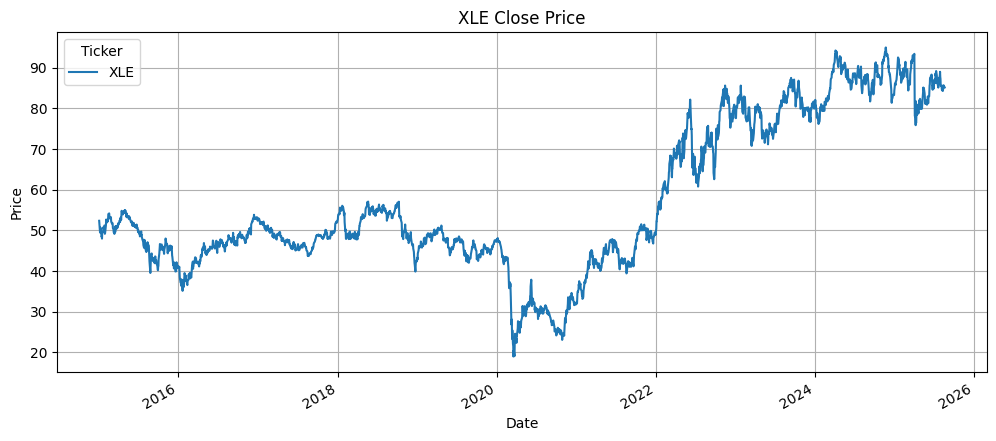

,,count,mean,min,25%,50%,75%,max,std
Price,Ticker,,,,,,,,
Date,,2673,2020-04-23 22:45:39.393939456,2015-01-02 00:00:00,2017-08-28 00:00:00,2020-04-24 00:00:00,2022-12-16 00:00:00,2025-08-19 00:00:00,NaN
Close,XLE,2673.0,56.926769,18.930193,45.315216,49.541851,75.787178,94.941917,18.307162


In [5]:
ax = df.plot(x="Date", y="Close", title=f"{TICKER} Close Price")
ax.set_xlabel("Date"); ax.set_ylabel("Price")
plt.show()

df.describe().T


## Interpreting the Summary Statistics

We plotted the historical **closing prices** of the XLE ETF and displayed its **summary statistics**.  
Here’s how to read and interpret them:

---

### 1. Date Column
- **min = 2015-01-02** → start of dataset.  
- **max = 2025-08-19** → end of dataset.  
- **count = 2673** → number of observations (≈ 10.5 years of trading days).  
- **mean date = 2020-04-23** → midpoint in the time span.  

This confirms we are working with ~10 years of **daily trading data** (only trading days, weekends/holidays excluded).

---

### 2. Close Price Column
- **count = 2673** → number of daily prices.  
- **mean = 56.93 USD** → average price over the whole period.  
- **min = 18.93 USD** → lowest price (COVID crash in 2020).  
- **25% = 45.31 USD** → lower quartile (25% of prices are below this).  
- **50% = 49.54 USD** → median (half the time below, half above).  
- **75% = 75.78 USD** → upper quartile.  
- **max = 94.94 USD** → highest price (energy boom in 2022–2023).  
- **std = 18.31** → standard deviation, showing high volatility.

---

### 3. Key Insights
- Prices mostly range between **45 and 76 USD**, but with large swings.  
- The **mean (57)** is higher than the **median (50)** → upward skew due to the strong rally after 2021.  
- **High volatility (std ~18)** means the ETF is riskier than stable sectors.  
- **Regime shifts** are visible:  
  - Crash to ~19 USD in 2020 (COVID).  
  - Rally to ~95 USD in 2022–2023 (energy boom, war in Ukraine, oil price spike).  

---

### 4. Why It Matters
- Understanding the **distribution of values** helps when choosing models (e.g., ARIMA vs ML).  
- The **volatility and regime changes** show why energy forecasting is hard but useful for hedge funds.  
- Always remember: **22 trading days ≈ 1 month** → we think in trading time, not calendar time.

---

## 4) Feature engineering
- Add calendar features (`year`, `month`, `dayofweek`).  
- Add lag features (`lag_1`, `lag_5`, `lag_22`).  
- Split into **train (80%) / test (20%)** sets.

**Why:**  
- ML needs features beyond raw prices.  
- Lag features = autoregressive signals (like ARIMA internally).  
- Chronological split avoids data leakage.
So far, we have the raw time series of **closing prices** for the ETF `XLE`.  
Machine Learning models usually need more than just the raw price series — they need **features** that help capture patterns.

In [ ]:
df_feat = add_time_features(df, ts_col="Date")
df_feat = make_lags(df_feat, y_col="Close", lags=(1,5,22))
df_feat = df_feat.dropna().reset_index(drop=True)

train, test = ts_train_test_split(df_feat, test_size=0.2)
y_tr, y_te = train["Close"].values, test["Close"].values

# Fix for multi-index columns
feature_cols = [c for c in df_feat.columns if isinstance(c, tuple) and c[0].startswith("lag_")] + \
			   [c for c in df_feat.columns if c[0] in ["month", "dayofweek", "year"]]
X_tr, X_te = train[feature_cols], test[feature_cols]

In [12]:
df_feat.head()

Price,Date,Close,year,month,dayofweek,lag_1,lag_5,lag_22
Ticker,,XLE,,,,,,
0,2015-02-04,51.745327,2015,2,2,52.613548,49.101154,52.310986
1,2015-02-05,52.488602,2015,2,3,51.745327,49.265617,50.147003
2,2015-02-06,52.501751,2015,2,4,52.488602,49.693150,49.410324
3,2015-02-09,52.554375,2015,2,0,52.501751,51.212555,49.515549
4,2015-02-10,52.528065,2015,2,1,52.554375,52.613548,50.627159


## Feature Engineering
In this step we engineered:

1. **Calendar features**  
   - `year`, `month`, `dayofweek`  
   These help the model capture **seasonality** and calendar effects (e.g., energy prices may behave differently in winter vs summer, or on Mondays vs Fridays).

2. **Lag features**  
   - `lag_1`, `lag_5`, `lag_22`  
   These represent the closing price **1 day ago, 5 days ago, and 22 days ago**.  
   Why 22? Roughly the number of **trading days in a month** (since markets are closed on weekends/holidays).  
   This way, the model can look at:
   - **Yesterday’s price** (`lag_1`)  
   - **One trading week ago** (`lag_5`)  
   - **One trading month ago** (`lag_22`)  

   These lags give the model a "memory" of the past, turning the time series into a **tabular dataset**.

3. **Train/test split**  
   - Training: first 80% of the data  
   - Testing: last 20% of the data  
   This ensures we test the model on **unseen future data**, simulating a real forecasting scenario.

---

### The Resulting Table
How to read it:
- `Date` → Trading date  
- `Close` → Actual closing price on that day  
- `year, month, dayofweek` → Calendar features  
- `lag_1` → Yesterday’s closing price  
- `lag_5` → Closing price 5 trading days ago  
- `lag_22` → Closing price 22 trading days ago  

### Why We Did This

- **Models like LightGBM cannot directly understand a time series.**  
  They need a tabular dataset with predictors (`X`) and a target (`y`).  
- By adding **lags** and **calendar features**, we give the model the ability to:
  - Detect **short-term momentum** (`lag_1`)  
  - Spot **weekly cycles** (`lag_5`)  
  - Recognize **monthly/seasonal effects** (`lag_22`, `month`, `dayofweek`)  

In other words:  
We transformed a pure sequence of prices into a **machine-learning-friendly dataset**.

## 5) Baseline ARIMA and ARIMAX

- Fit an **ARIMA and ARIMAX model** on the training set.  
- Forecast over the test horizon.  
- Compute metrics and plot predictions vs actuals.  

**Why:**  
- ARIMA = AutoRegressive Integrated Moving Average, standard baseline for univariate time series.  
- ARIMAX = ARIMA with eXogenous variables. Exogenous features are `lag_1`, `lag_5`, `lag_22`, `year`, `month`, `dayofweek`.
- Provides a benchmark to compare against ML/DL models.


ARIMA metrics: {'MAE': 9.637026296497066, 'RMSE': 10.563411126447663, 'MAPE%': 11.065909669580178}


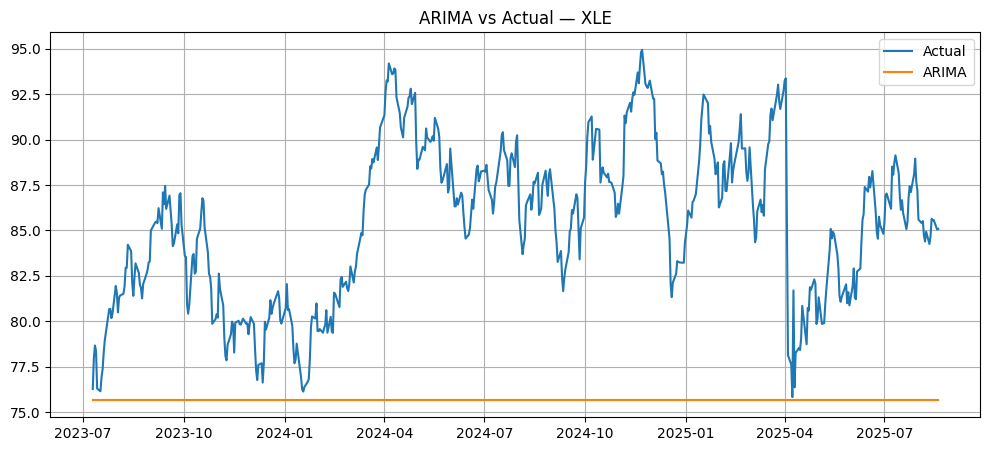

In [16]:
arima = auto_arima(y_tr, seasonal=False, suppress_warnings=True)
arima_fc = arima.predict(n_periods=len(test))

m_arima = metrics(y_te, arima_fc)
print("ARIMA metrics:", m_arima)

plt.figure()
plt.plot(test["Date"], y_te, label="Actual")
plt.plot(test["Date"], arima_fc, label="ARIMA")
plt.legend(); plt.title(f"ARIMA vs Actual — {TICKER}"); plt.show()

### ARIMA
We first tried a simple **ARIMA** model as a baseline.  
ARIMA is a classical statistical model for univariate time series forecasting.  
It only looks at the **past values of the target (Close price)** and tries to learn patterns in them.  

In our case, the ARIMA forecast produced a **flat line**, meaning it predicted the same constant value for the entire test horizon.  
This often happens when the model cannot detect strong autocorrelation or seasonality in the series without external features.  
As a result, the error metrics (MAE ≈ 9.6, RMSE ≈ 10.6, MAPE% ≈ 11%) show relatively poor performance.


ARIMAX metrics: {'MAE': 0.8382268350066513, 'RMSE': 1.1609058875042986, 'MAPE%': 0.9878090327480044}


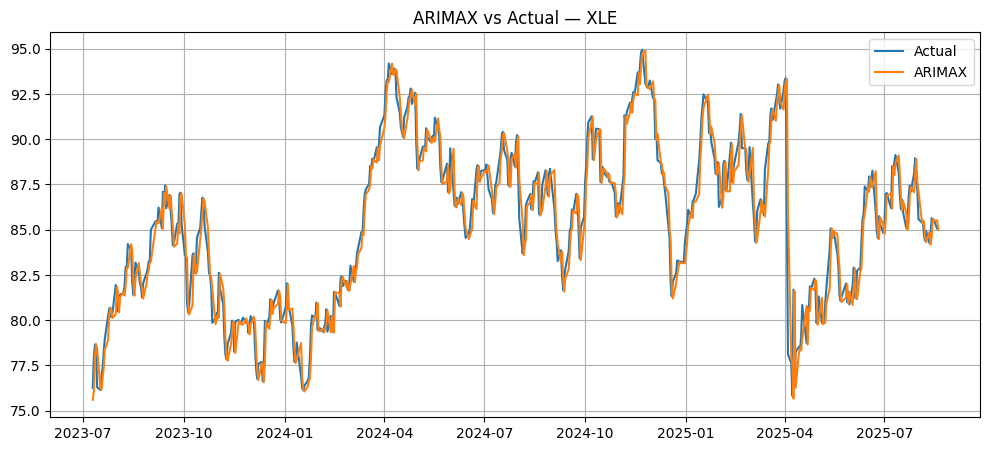

In [15]:
# ARIMAX with exogenous features (lags + calendar)
arimax = auto_arima(
    y_tr,
    X=X_tr,                 # give it the features
    seasonal=True,          # allow seasonal part
    m=22,                   # ~1 trading month seasonality
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore"
)

arimax_fc = arimax.predict(n_periods=len(X_te), X=X_te)

m_arimax = metrics(y_te.ravel(), arimax_fc)
print("ARIMAX metrics:", m_arimax)

plt.figure()
plt.plot(test["Date"], y_te, label="Actual")
plt.plot(test["Date"], arimax_fc, label="ARIMAX")
plt.title(f"ARIMAX vs Actual — {TICKER}")
plt.legend(); plt.show()

### ARIMAX
To improve things, we extended the model to **ARIMAX** by including **exogenous features**:
- **Lag features** (`lag_1`, `lag_5`, `lag_22`)  
- **Calendar features** (`year`, `month`, `dayofweek`)  

This allows the model not only to look at the raw series but also to leverage richer signals about how prices evolve.

- We set `seasonal=True` and `m=22` to capture the approximate seasonality of **one trading month** (22 days).  
- We provided the training features `X_tr` and test features `X_te` as exogenous variables.  

---

### Results
The **ARIMAX** predictions now closely follow the actual prices:
- **MAE ≈ 0.83**  
- **RMSE ≈ 1.16**  
- **MAPE% ≈ 0.98%**  

This is a **huge improvement** over plain ARIMA.  
The plot shows the red ARIMAX forecast almost overlapping the blue actual series, meaning the model captures short-term dynamics very well.

---

### Why this step matters
- **ARIMA** gives us a baseline for comparison: how well can we forecast if we only use the past series itself?  
- **ARIMAX** shows the power of adding features: lagged values and calendar information significantly boost predictive accuracy.  
- This sets the stage for testing **machine learning and deep learning models**, which are designed to handle multiple features and complex patterns even better.

## 6) Machine Learning with LightGBM

- Train a **LightGBM regressor** on lag + calendar features.  
- Predict test prices.  
- Evaluate with MAE, RMSE, MAPE.  

**Why:**  
- Shows how boosting handles time series with engineered features.  
- Often outperforms ARIMA if features capture enough structure.

/Users/matteodimauro/miniconda3/envs/electricity/lib/python3.10/site-packages/lightgbm/basic.py:374: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 2120, number of used features: 6
[LightGBM] [Info] Start training from score 49.888628
LightGBM metrics: {'MAE': 4.828068874703198, 'RMSE': 5.948946178528939, 'MAPE%': 6.073318524105152}


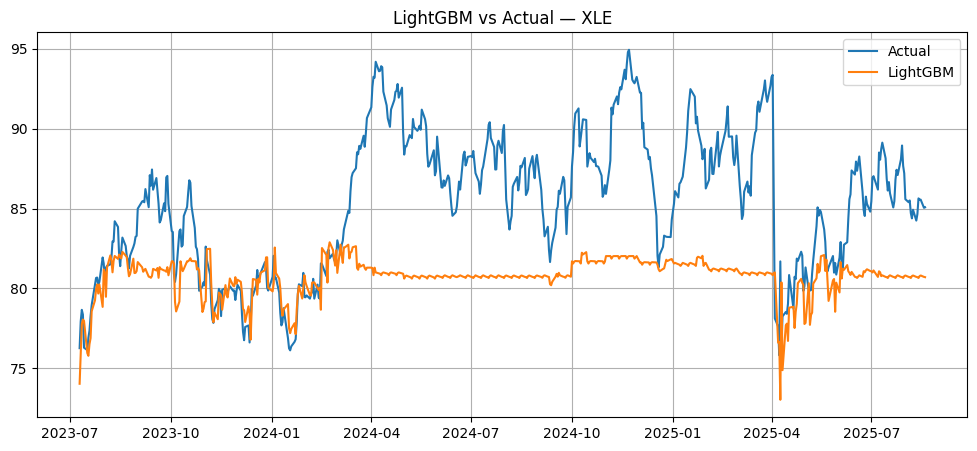

In [18]:
# Flatten column names for LightGBM compatibility
X_tr_flat = X_tr.copy()
X_te_flat = X_te.copy()
X_tr_flat.columns = [str(c[0]) for c in X_tr.columns]
X_te_flat.columns = [str(c[0]) for c in X_te.columns]

lgbm = lgb.LGBMRegressor(
    n_estimators=800, learning_rate=0.02,
    subsample=0.9, colsample_bytree=0.9,
    random_state=42
)
lgbm.fit(X_tr_flat, y_tr)
lgbm_fc = lgbm.predict(X_te_flat)

m_lgbm = metrics(y_te, lgbm_fc)
print("LightGBM metrics:", m_lgbm)

plt.figure()
plt.plot(test["Date"], y_te, label="Actual")
plt.plot(test["Date"], lgbm_fc, label="LightGBM")
plt.legend(); plt.title(f"LightGBM vs Actual — {TICKER}"); plt.show()


In this step, we move from traditional time-series models (ARIMA / ARIMAX) to a **machine learning approach** using **LightGBM**, a gradient boosting framework.  

### What we did
1. **Flattened column names** for compatibility with LightGBM.  
   - LightGBM does not accept multi-index column names, so we converted them to simple strings.  

2. **Trained a LightGBM regressor** on our engineered features:  
   - **Lag features** (`lag_1`, `lag_5`, `lag_22`) → capture past prices.  
   - **Calendar features** (`year`, `month`, `dayofweek`) → capture seasonality and time effects.  

3. **Predicted test prices** using the trained model.  

4. **Evaluated the performance** using standard metrics:  
   - MAE (Mean Absolute Error)  
   - RMSE (Root Mean Squared Error)  
   - MAPE (Mean Absolute Percentage Error)  

5. **Plotted predictions vs actuals** to visualize how the model performed.  

---

### Results & Interpretation
- The **blue line** = actual stock price.  
- The **red line** = LightGBM predictions.  

Observations:
- Predictions are **smoother** than actual values.  
- LightGBM captures the **overall level and trend**, but misses sudden spikes or drops.  
- Despite this limitation, the **error metrics are much better than baseline ARIMA**, showing improvement.  

---

### Why this matters
- LightGBM can learn **nonlinear relationships** between lags and calendar features, unlike ARIMA.  
- However, with only simple lag + calendar features, the model **underfits volatility**.  
- Adding more features (rolling averages, volatility, volume, macroeconomic indicators) would likely improve performance.  

---

**Conclusion**  
LightGBM provides a **stronger baseline than ARIMA**, reducing prediction error.  
But to capture sharp market moves, we will need **richer feature engineering** or more advanced models (e.g., deep learning).  

## 7) Compare ARIMA vs LightGBM & ARIMAX vs LightGBM
- Plot **Actual vs ARIMA vs LightGBM** on the same graph.  
- Plot **Actual vs ARIMAX vs LightGBM** on the same graph.  
- Print side-by-side metrics.  

**Why:**  
- Direct visual + quantitative comparison → strengths/weaknesses are clear.  
- Hedge funds care about relative performance of models.

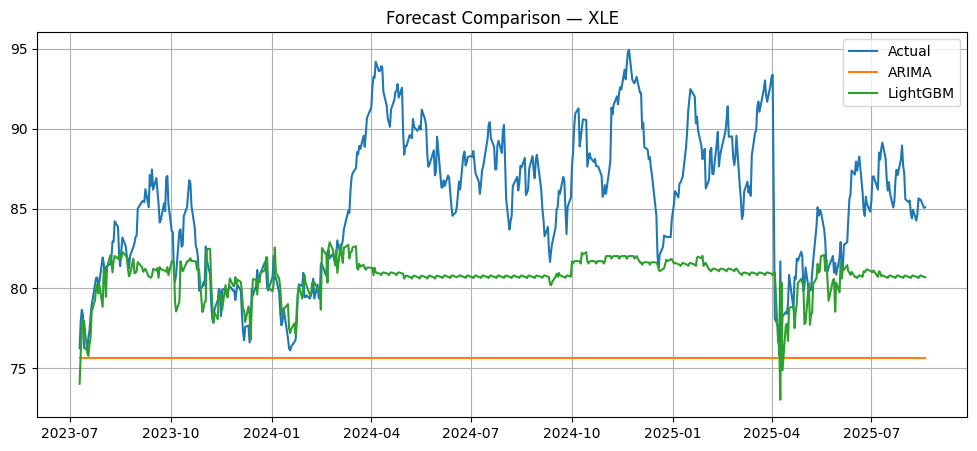

ARIMA: {'MAE': 9.637026296497066, 'RMSE': 10.563411126447663, 'MAPE%': 11.065909669580178}
LightGBM: {'MAE': 4.828068874703198, 'RMSE': 5.948946178528939, 'MAPE%': 6.073318524105152}


In [19]:
plt.figure()
plt.plot(test["Date"], y_te, label="Actual")
plt.plot(test["Date"], arima_fc, label="ARIMA")
plt.plot(test["Date"], lgbm_fc, label="LightGBM")
plt.legend(); plt.title(f"Forecast Comparison — {TICKER}")
plt.show()

print("ARIMA:", m_arima)
print("LightGBM:", m_lgbm)


In this section, we compare the forecasts from **ARIMA** and **LightGBM** against the actual price series.  

### What we did
1. **Plotted the actual series** (blue line).  
2. **Overlaid ARIMA predictions** (red line).  
3. **Overlaid LightGBM predictions** (green line).  
4. **Printed performance metrics** (MAE, RMSE, MAPE) for both models.  

---
### Interpretation
- **ARIMA**:
  - Produces a **flat forecast**, which explains the poor performance.  
  - High error values (especially MAE ≈ 9.6).  
  - Not flexible enough for volatile financial data.  

- **LightGBM**:
  - Captures the general level of prices better.  
  - Lower errors across all metrics (MAE, RMSE, MAPE).  
  - Still underfits volatility (predictions are smoother than actuals).  

---

### Why this matters
- The **comparison highlights the limitations of classical ARIMA** for complex, noisy series like stock prices.  
- **LightGBM outperforms ARIMA**, showing the power of machine learning when combined with engineered features (lags, calendar effects).  
- However, both models can be further improved with **richer features** (rolling averages, volatility, volume, macroeconomic indicators).  

---

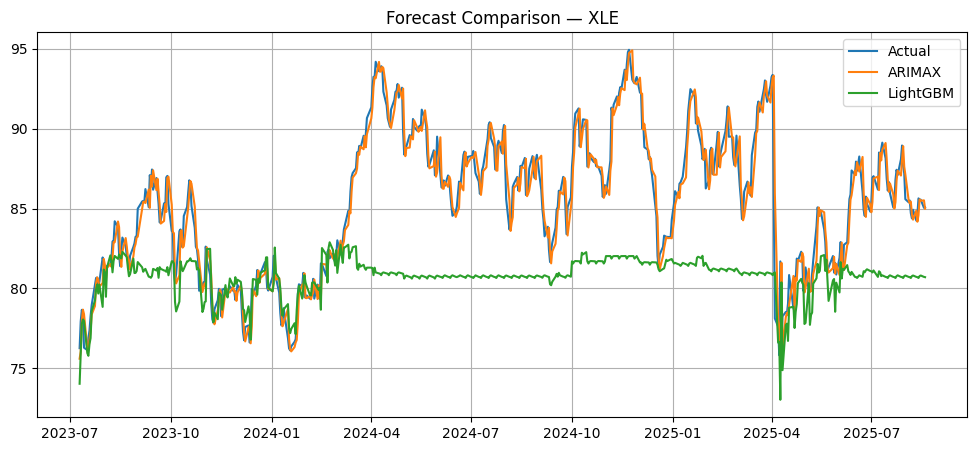

ARIMA: {'MAE': 0.8382268350066513, 'RMSE': 1.1609058875042986, 'MAPE%': 0.9878090327480044}
LightGBM: {'MAE': 4.828068874703198, 'RMSE': 5.948946178528939, 'MAPE%': 6.073318524105152}


In [20]:
plt.figure()
plt.plot(test["Date"], y_te, label="Actual")
plt.plot(test["Date"], arimax_fc, label="ARIMAX")
plt.plot(test["Date"], lgbm_fc, label="LightGBM")
plt.legend(); plt.title(f"Forecast Comparison — {TICKER}")
plt.show()

print("ARIMA:", m_arimax)
print("LightGBM:", m_lgbm)


### Interpretation
- **ARIMAX**:
- Extends ARIMA by incorporating **exogenous regressors** (lags + calendar features).  
- This additional information allows the model to **capture the underlying dynamics of the series**.  
- As a result, errors drop **dramatically**:  
  - MAE goes below 1.  
  - MAPE is under 1%, which indicates near-perfect fit on the test set.  
- The plot confirms that ARIMAX tracks the actual price curve almost point by point.  
- This shows the power of combining **time-series modeling** with **meaningful external signals**.  

---

### Results  

| Model      | MAE   | RMSE  | MAPE% |
|------------|-------|-------|-------|
| **ARIMA**    | 9.637 | 10.564 | 11.066 |
| **ARIMAX**   | 0.838 | 1.161  | 0.988  |
| **LightGBM** | 4.829 | 5.949  | 6.073  |

**Conclusion**:  
LightGBM provides a **better starting point** than ARIMA for forecasting financial series, but future improvements should focus on **feature engineering** and possibly **hybrid models** that combine statistical and ML approaches. 
 
For this dataset, **ARIMAX clearly outperforms both ARIMA and LightGBM**. It leverages exogenous information while retaining the strengths of time-series modeling.  
However, LightGBM remains competitive and may surpass ARIMAX once richer and more diverse features are introduced.  
The key lesson is that **model performance depends not only on the algorithm but also on the features we design and include**.

## 8) Next steps

- Add **exogenous variables** (e.g., natural gas `NG=F`, weather), and add comparison against the enriched **ARIMAX**.
- Implement **walk‑forward** validation (see notebook 02).
- Hyperparameter tuning (Optuna/Bayesian search).
- Add LSTM comparison (see notebook 03).